<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/evaluation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Evaluation

In this exercise, we will understand how to do performance evaluation of machine learning models. Let's begin with importing some functions.

Please pay particular attention to the exercise questions at the end of this notebook.

In [1]:
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:
            conts = sorted([-1+eps,0,1-eps])

    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)

        z = np.reshape(z,(npts,npts)).T


        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)

    if Y is not None:
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)

    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    if not hold:
        plt.grid()
        plt.show()
    return extent

def getExamples(n=100,d=2):
    """
    Generates n d-dimensional normally distributed examples of each class
    The mean of the positive class is [1] and for the negative class it is [-1]
    """
    Xp = randn(n,d)#+1   #generate n examples of the positie class
    Xp=Xp+1
    Xn1 = randn(int(n/2),d)#-1   #generate n examples of the negative class
    Xn1=Xn1-1
    Xn2 = randn(int(n/2),d)#-1   #generate n examples of the negative class
    Xn2=Xn2+2
    Xn = np.vstack((Xn1,Xn2))  #Stack the examples together to a single matrix
    X = np.vstack((Xp,Xn))  #Stack the examples together to a single matrix
    Y = np.array([+1]*n+[-1]*n) #Associate Labels
    return (X,Y)
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
def plotROC(y,z,pstr = ''):
    fpr,tpr,tt = roc_curve(y, z)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(tt,fpr,'o-',tt,tpr,'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['FPR','TPR']);plt.grid();plt.title(pstr)
    plt.figure()
    plt.plot(fpr,tpr,'o-');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.title('ROC '+pstr+' AUC: '+str(roc_auc))
    return roc_auc

def plotPRC(y,z,pstr = ''):
    P,R,tt = precision_recall_curve(y, z)
    pr_auc = average_precision_score(y, z)
    plt.figure()
    plt.plot(tt,R[:-1],'o-',tt,P[:-1],'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['Recall','Precision']);plt.grid();plt.title(pstr)
    plt.figure()
    plt.plot(R,P,'o-');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.title('PRC '+pstr+' AUC: '+str(pr_auc))
    return pr_auc




Let's use a train test split function to evaluat ethe performance of an SVM on some held-out data after training.

You can try other classifiers to see their impact. If you want to use the same train test split across classifiers you can fix the random_state.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


X,y = getExamples(n=100)
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2, shuffle = True, stratify = None)#, random_state=42)

clf = SVC(C=10.0, kernel='rbf',gamma = 1.0) #degree, coef0, gamma='scale',, class_weight=None
clf.fit(Xtr,ytr)
zv = clf.decision_function(Xv)
# calculate the number of true poisitives and false positives at a threshold of t
t = 0
pred = 2*(zv>t)-1
print('Accuracy',np.mean(pred==yv))

tpr = np.sum((pred==1)*(yv==1))/np.sum(yv==1)
fpr = np.mean((pred==1)*(yv==-1))
precision = np.sum((pred==1)*(yv==1))/np.sum(pred==1)
print('TPR:',tpr,'FPR:',fpr)
print('Precision:',precision)

Accuracy 0.725
TPR: 0.8666666666666667 FPR: 0.225
Precision: 0.5909090909090909


Let's plot the true positive rate and false positive rate vs the threshold of classification for both the training and validation data. Is the classifier performing better over training or over validation data?

<ipython-input-1-4acd413e8e4f>:58: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


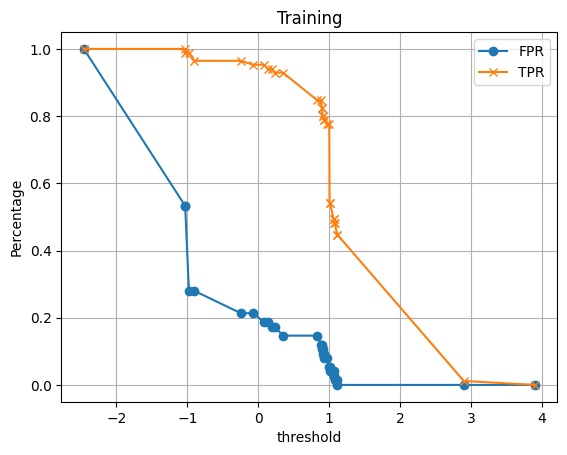

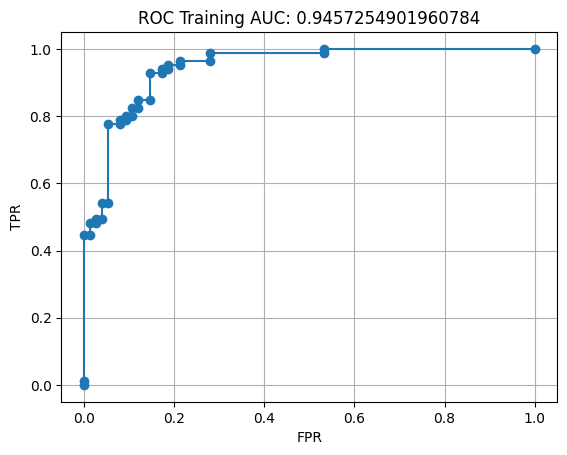

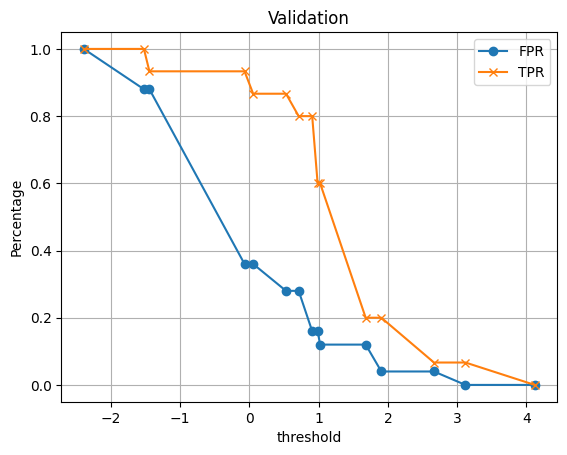

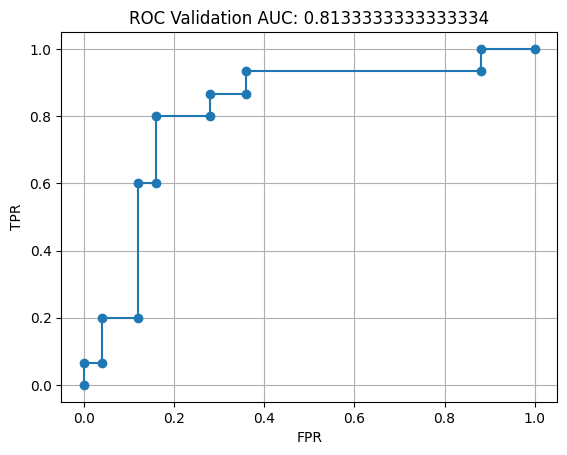

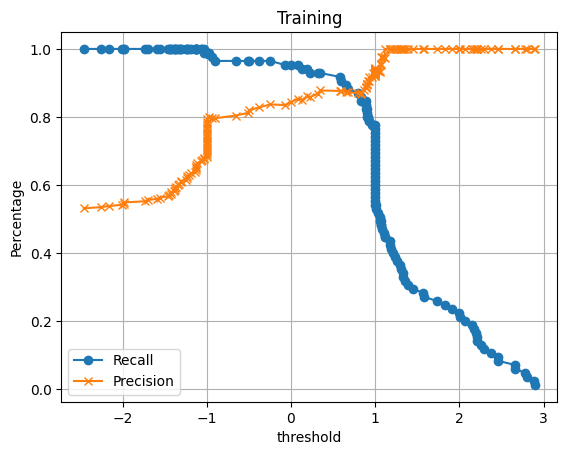

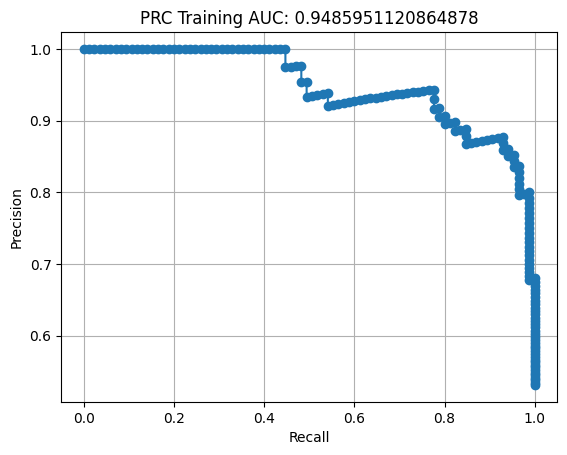

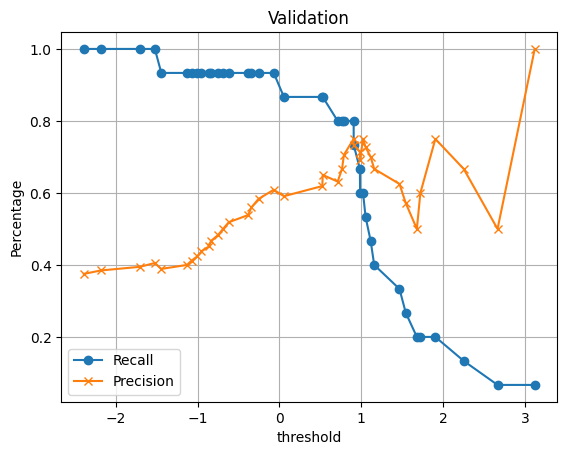

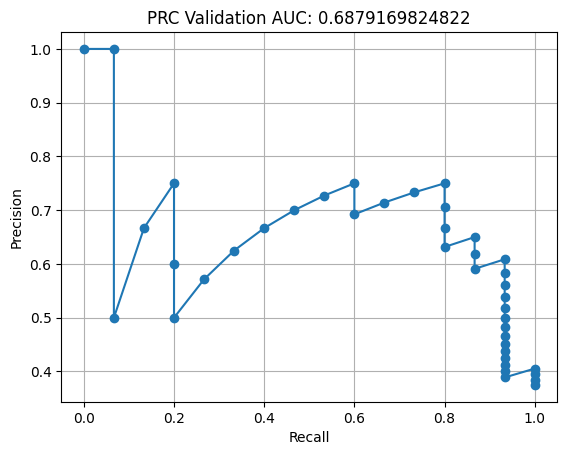

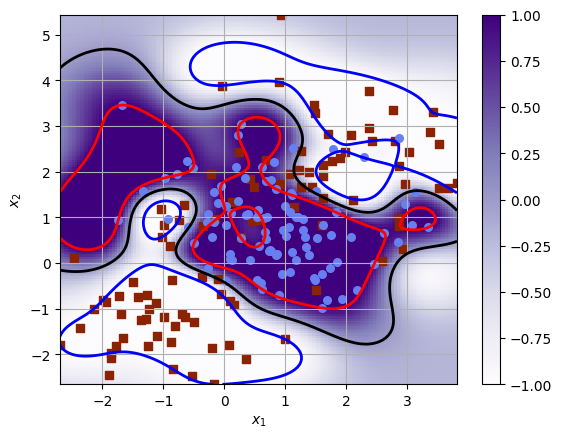

Training AUC ROC: 0.9457254901960784
Validation AUC ROC: 0.8133333333333334


In [3]:
# plot fpr and tpr vs. thrshold and roc
roc_tr = plotROC(ytr,clf.decision_function(Xtr),'Training')
roc_v = plotROC(yv,zv,'Validation')
pr_tr = plotPRC(ytr,clf.decision_function(Xtr),'Training')
pr_v = plotPRC(yv,zv,'Validation')


plt.figure()
plotit(X = X, Y = y, clf = clf.decision_function, conts =[-1,0,1], colors = 'random')

print('Training AUC ROC:', roc_tr)
print('Validation AUC ROC:', roc_v)

Let's perform K-Fold cross-validation. Why is it important to do it in a stratified manner?

Fold  0 AUC ROC: 0.7925
Fold  1 AUC ROC: 0.8325
Fold  2 AUC ROC: 0.8475
Fold  3 AUC ROC: 0.8274999999999999
Fold  4 AUC ROC: 0.895
Fold-Wise AUC [0.7925, 0.8325, 0.8475, 0.8274999999999999, 0.895]
Mean AUC 0.8390000000000001
Stdev AUC 0.03330165161069344


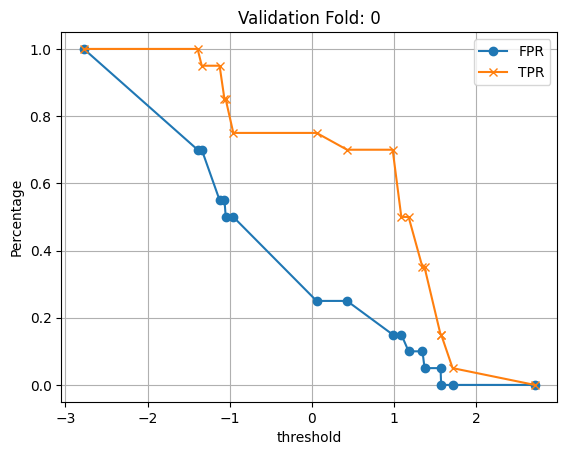

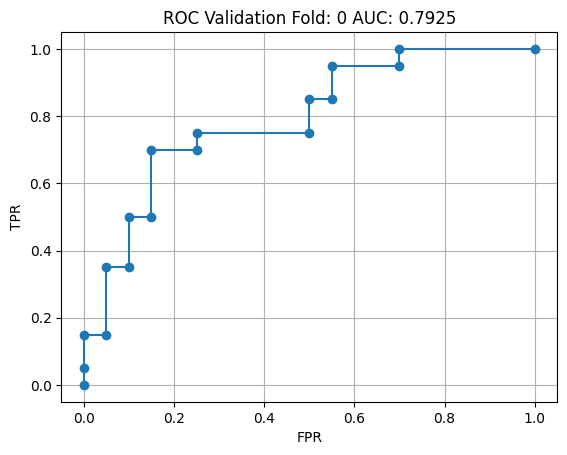

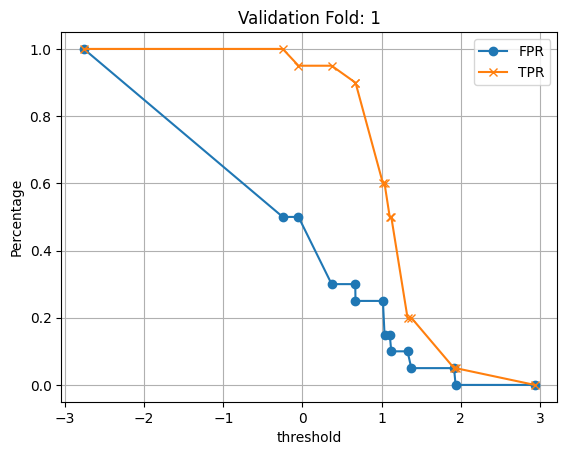

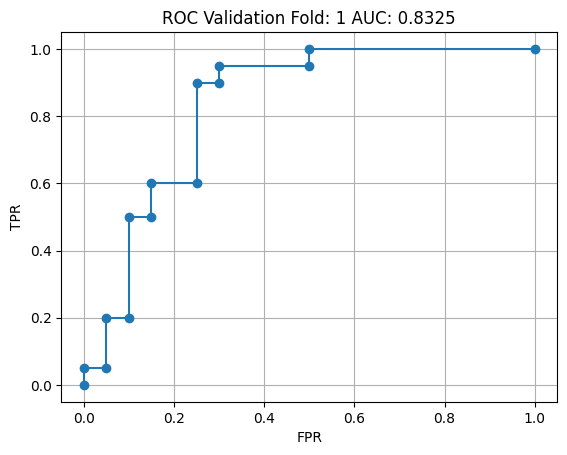

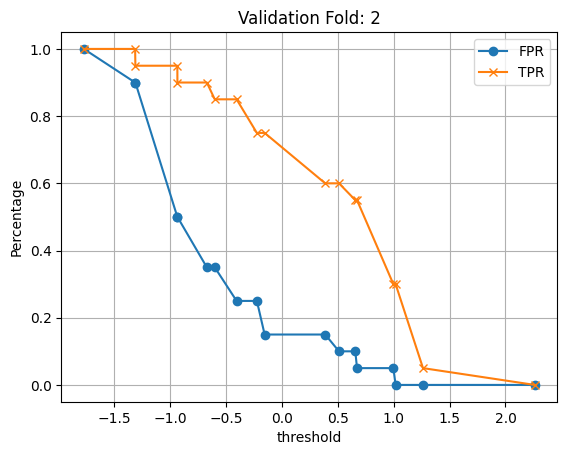

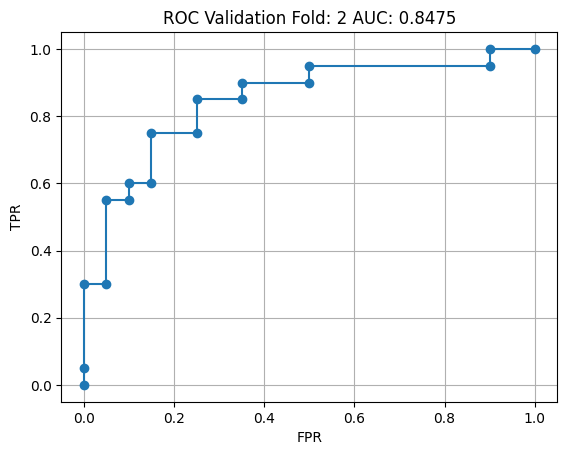

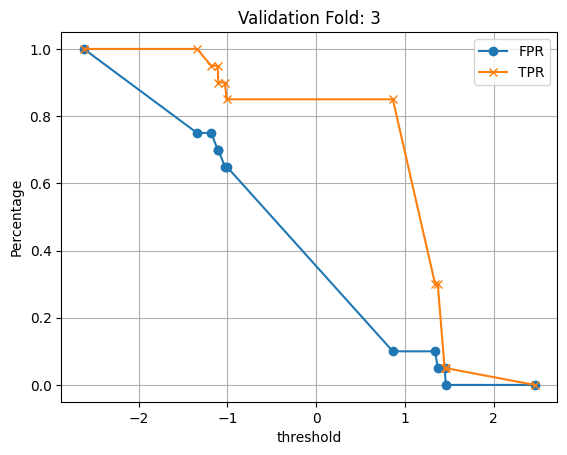

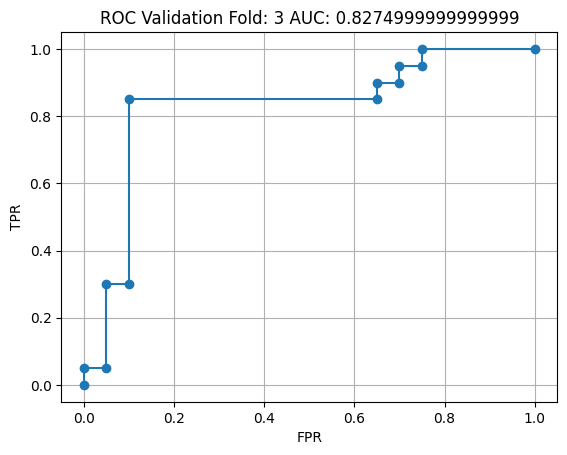

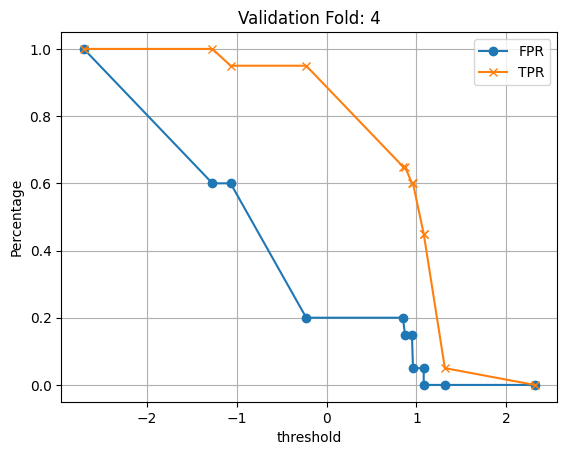

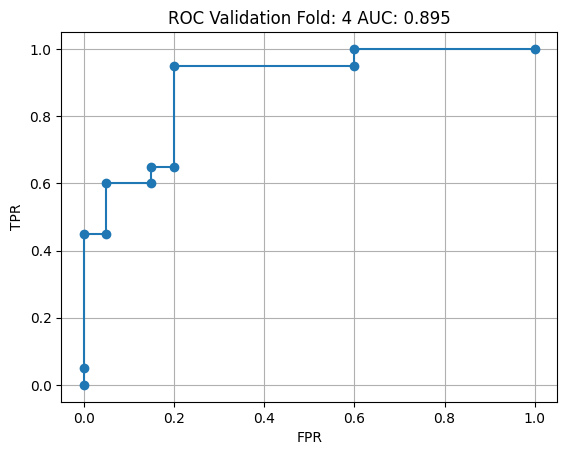

In [4]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle = True)
A = []
for i,(tr_idx, v_idx) in enumerate(skf.split(X, y)):
  Xtr, Xv = X[tr_idx], X[v_idx]
  ytr, yv = y[tr_idx], y[v_idx]
  clf = SVC(C=10.0, kernel='rbf',gamma = 1.0) #degree, coef0, gamma='scale',, class_weight=None
  clf.fit(Xtr,ytr)
  z = clf.decision_function(Xv)
  roc_auc = plotROC(yv,z,pstr = 'Validation Fold: '+str(i))
  A.append(roc_auc)
  print('Fold ',i,'AUC ROC:',roc_auc)

print('Fold-Wise AUC',A)
print('Mean AUC',np.mean(A))
print('Stdev AUC',np.std(A))


Let's train the model over the training set and the test it on a test set to simulate a deployment scenario. Ideally, we would like the training, validation and test performance metrics to be comparable to ensure good generalization.

<ipython-input-1-4acd413e8e4f>:58: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


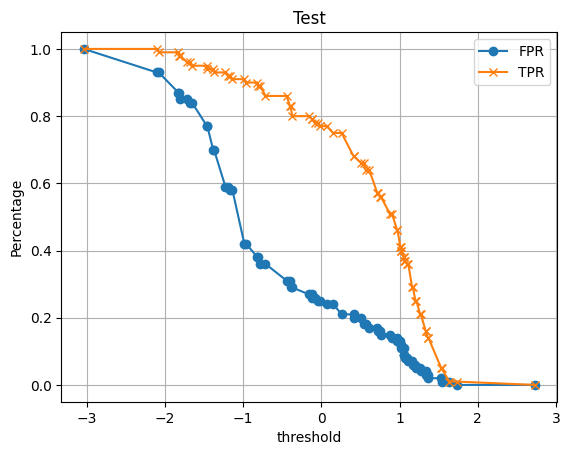

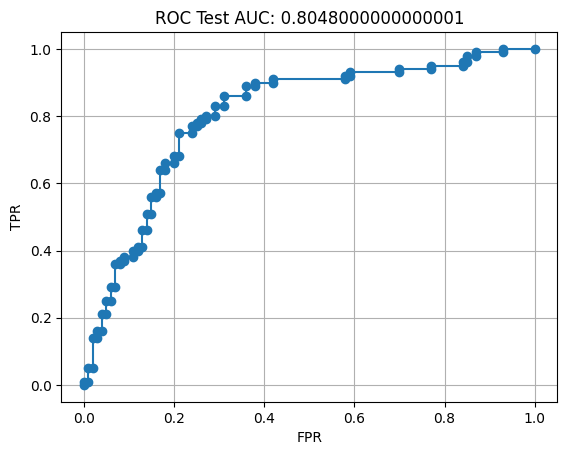

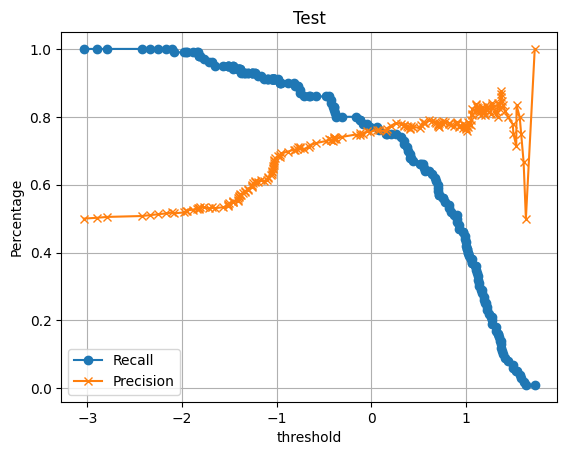

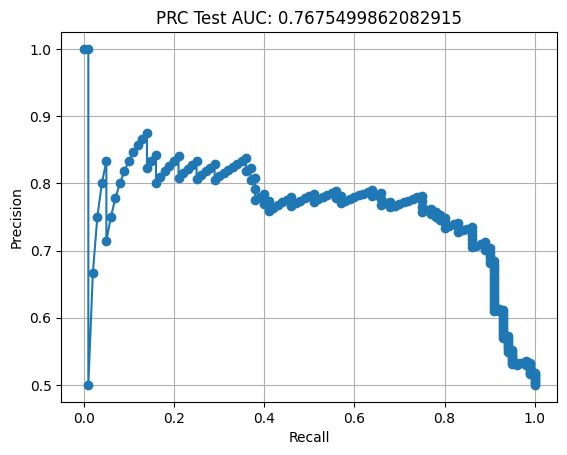

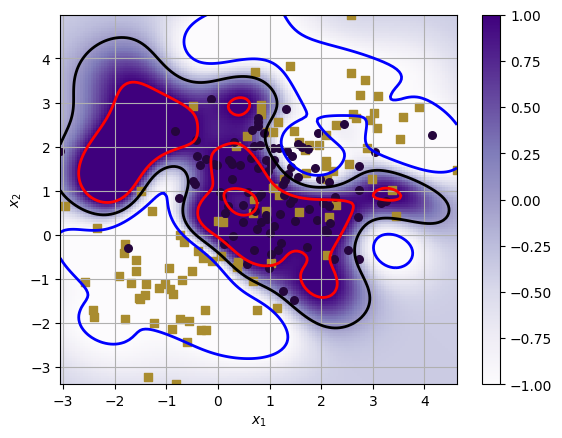

Test AUC ROC: 0.8048000000000001


In [5]:
#Final model training on all data prior to "deployment"
clf = SVC(C=10.0, kernel='rbf',gamma = 1.0).fit(X,y)
#testing
Xtt,ytt = getExamples(n=100)
roc_tt = plotROC(ytt,clf.decision_function(Xtt),'Test')
pr_tt = plotPRC(ytt,clf.decision_function(Xtt),'Test')
plt.figure()
plotit(X = Xtt, Y = ytt, clf = clf.decision_function, conts =[-1,0,1], colors = 'random')

print('Test AUC ROC:', roc_tt)

The code below calculates the probability of a randomly selected positive example to be scored higher than a randomly selected negative example. How does it related to AUC-ROC?

In [18]:
ztt = clf.decision_function(Xtt)
pos_idx, neg_idx = np.where(ytt==1)[0], np.where(ytt!=1)[0]
N_pairs = 10000
sampled_pos_idx = np.random.choice(pos_idx, size=N_pairs, replace=True)
sampled_neg_idx = np.random.choice(neg_idx, size=N_pairs, replace=True)
p = np.mean(ztt[sampled_pos_idx]>ztt[sampled_neg_idx])
print('Probability of a positive example being scored higher than a negative example',p)

Probability of a positive example being scored higher than a negative example 0.817


Questions:

0. What is the difference between training, validation and test examples? What is the goal of using each type of examples?
1. What is stratified validation?
2. What are underlying assumptions for accuracy as a metric?
3. What is precision, recall, false positive rate?
4. Why are accuracy, precision, recall etc. dependent upon the threshold of the classifier?
5. How do precision, recall and false positive rate change as the threshold of the classifier is increased?
6. What is the ROC curve?
7. How does area under the ROC curve serve as a performance metric? How does it relate to the probability that a randomly picked positive example will be scored higher by a classifier than a randomly picked negative example?
8. Why is the ROC curve called the ROC curve?
9. How does the performance estimate of your model change with increase in the size of your validation set?
10. What are the limitations of ROC curves?
11. What is the most important region of an ROC curve?
12. How is a precision recall curve useful?
13. What is the relationship between the ROC and Precision-Recall curves?
14. What are the limitations of the precision recall curve?
15. How do we train the final model for deployment?
16. How can you chose an "operating point" for a machine learning model?
17. Consider a binar classification problem in which the number of negative examples is roughly equal to the number of positive examples. If I use a random classifier (one that generates random scores between -1 and +1 inclusive), what will be the value of each of the following metrics for this classifier (you can choose a threshold of zero for metrics that require a threshold for their computation): Accuracy, Balanced Accuracy, AUC-ROC, AUC-PR, F1, MCC?
18. Consider a binar classification problem in which the number of negative examples is 9 times more than the number of positive examples. If I use a random classifier (one that generates random scores between -1 and +1 inclusive), what will be the value of each of the following metrics for this classifier (you can choose a threshold of zero for metrics that require a threshold for their computation): Accuracy, Balanced Accuracy, AUC-ROC, AUC-PR, F1, MCC?
19. Consider a binar classification problem in which the number of negative examples is roughly equal to the number of positive examples. If I use a  classifier that always predicts a score of 1.0 for any example, what will be the value of each of the following metrics for this classifier (you can choose a threshold of zero for metrics that require a threshold for their computation): Accuracy, Balanced Accuracy, AUC-ROC, AUC-PR, F1, MCC?
20. Consider a binar classification problem in which the number of negative examples is roughly equal to the number of positive examples. If I use a  classifier that always predicts a score of 1.0 for any example, what will be the value of each of the following metrics for this classifier (you can choose a threshold of zero for metrics that require a threshold for their computation): Accuracy, Balanced Accuracy, AUC-ROC, AUC-PR, F1, MCC?
21. Unlike the ROC curve, the PR curve is non-montonous. Why is this the case?
22. How do each of FPR, TPR and precision change as the threshold is increased from very small values to very large values?

